In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Trends with the GOZCARDS Dataset

Here we calculate trends using the GOZCARDS dataset by regressing to the VMR monthly zonal means using seasonal terms in our predictors.

In [2]:
import xarray as xr
import numpy as np
from LOTUS_regression.regression import regress_all_bins
from LOTUS_regression.predictors.seasonal import add_seasonal_components
from LOTUS_regression.predictors import load_data

The GOZCARDS data is in multiple NetCDF4 files.  Load them all in and concatenate on the time dimension.  Also only take values in the latitude range -60 to 60.

In [3]:
GOZCARDS_FILES = r'/home/runner/work/lotus-regression/lotus-regression/test_data//GOZCARDS/*.nc4'
data = xr.decode_cf(xr.open_mfdataset(GOZCARDS_FILES, combine='nested', concat_dim='time', group='Merged', engine='netcdf4'))

data = data.loc[dict(lat=slice(-60, 60))]

print(data)

<xarray.Dataset> Size: 47MB
Dimensions:               (time: 384, data_source: 6, overlap: 6, lev: 25,
                           lat: 12)
Coordinates:
  * lat                   (lat) float32 48B -55.0 -45.0 -35.0 ... 35.0 45.0 55.0
  * lev                   (lev) float32 100B 1e+03 681.3 464.2 ... 0.1468 0.1
  * time                  (time) datetime64[ns] 3kB 1979-01-15 ... 2012-12-15
  * data_source           (data_source) int32 24B 1 2 3 4 5 6
  * overlap               (overlap) int32 24B 1 2 3 4 5 6
Data variables: (12/13)
    data_source_name      (time, data_source) |S20 46kB dask.array<chunksize=(12, 6), meta=np.ndarray>
    overlap_start_time    (time, overlap) datetime64[ns] 18kB dask.array<chunksize=(12, 6), meta=np.ndarray>
    overlap_end_time      (time, overlap) datetime64[ns] 18kB dask.array<chunksize=(12, 6), meta=np.ndarray>
    overlap_used_source   (time, overlap, data_source) int8 14kB dask.array<chunksize=(12, 6, 6), meta=np.ndarray>
    overlap_source_total  (time

Load some standard predictors and add a constant

In [4]:
predictors = load_data('pred_baseline_pwlt.csv')

print(predictors.columns)

Index(['enso', 'solar', 'qboA', 'qboB', 'aod', 'linear_pre', 'linear_post',
       'constant'],
      dtype='object')


Currently, our predictors have no seasonal dependence.  Add in some seasonal terms with different numbers of Fourier components.

In [5]:
predictors = add_seasonal_components(predictors, {'constant': 4, 'linear_pre': 2, 'linear_post': 2, 'qboA': 2, 'qboB': 2})

print(predictors[:5])

                enso     solar      qboA      qboB       aod  linear_pre  \
time                                                                       
1979-01-01  0.534698  1.578955 -1.067789  0.952231 -0.411760   -1.800000   
1979-02-01  0.351147  1.633527 -0.831698  0.892204 -0.412330   -1.791667   
1979-03-01  0.004440  1.318208 -1.168007  0.628544 -0.413462   -1.783333   
1979-04-01  0.269569  1.129935 -1.229261  0.561389 -0.416360   -1.775000   
1979-05-01  0.330752  1.002783 -1.226434  0.052783 -0.420368   -1.766667   

            linear_post  constant  qboA_sin0  qboA_cos0  ...  \
time                                                     ...   
1979-01-01          0.0       1.0  -0.000000  -1.067789  ...   
1979-02-01          0.0       1.0  -0.422799  -0.716214  ...   
1979-03-01          0.0       1.0  -0.992164  -0.616320  ...   
1979-04-01          0.0       1.0  -1.228947  -0.027752  ...   
1979-05-01          0.0       1.0  -1.080099   0.580970  ...   

            linear

Perform the regression and convert the coefficients to percent anomaly.

In [6]:
data = data.sel(lev=slice(100, 0.2)).sel(lat=slice(-65, 65))   # remove bins without data
results = regress_all_bins(predictors, data['average'], tolerance=0.1)

# Convert to ~ percent
results /= data['average'].mean(dim='time')
results *= 100

print(results)

<xarray.Dataset> Size: 105kB
Dimensions:               (lev: 17, lat: 12)
Coordinates:
  * lev                   (lev) float32 68B 100.0 68.13 46.42 ... 0.3162 0.2154
  * lat                   (lat) float32 48B -55.0 -45.0 -35.0 ... 35.0 45.0 55.0
Data variables: (12/64)
    enso                  (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    enso_std              (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    solar                 (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    solar_std             (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    qboA                  (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    qboA_std              (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    ...                    ...
    constant_cos2         (lev, lat) float64 2kB dask.array<chunksize=(17, 12), meta=np.ndarray>
    constant_cos2_

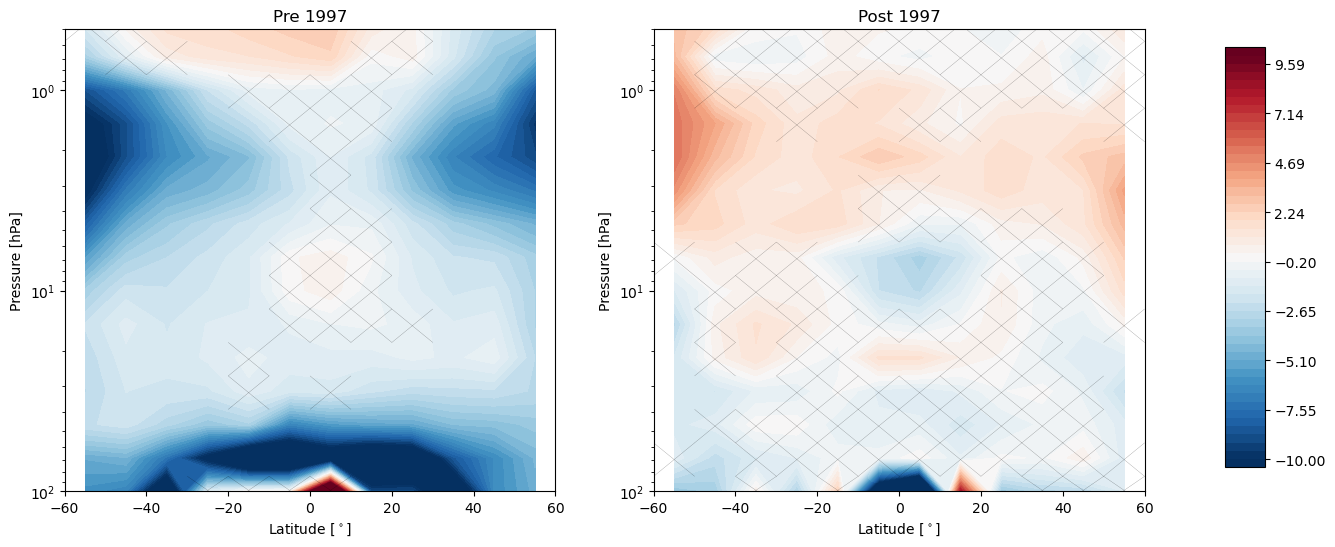

In [7]:
import LOTUS_regression.plotting.trends as trends
trends.pre_post_with_confidence(results, x='lat', y='lev', ylim=(100, 0.5), log_y=True, figsize=(16, 6),
                                x_label='Latitude [$^\circ$]', y_label='Pressure [hPa]', pre_title='Pre 1997',
                                post_title='Post 1997')